<a href="https://colab.research.google.com/github/zhulkhoirr/Steam-Recommendation-System/blob/main/SteamRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Rekomendasi Game Pada Platform Steam

## 1. Download Datasets Dari Kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d fronkongames/steam-games-dataset/

Dataset URL: https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/versions/
License(s): MIT
 96% 203M/211M [00:03<00:00, 97.0MB/s]
100% 211M/211M [00:03<00:00, 63.0MB/s]


In [ ]:
!unzip -q model.zip

In [9]:
!unzip -q steam-games-dataset.zip

In [ ]:
import zipfile

zip_filename = 'steam-games-dataset.zip'
file_to_extract = 'games.json'
output_directory = '.'

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extract(file_to_extract, output_directory)


## 2. Memahami Data

In [11]:
import numpy as np
import pandas as pd

In [12]:
recommendations_df = pd.read_csv('users.csv')

recommendations_df.sample(5)

UserID    AppID  Playtime  Rating  IsRecommended
12   6184540493100478  2641470       1.0       4              1
177  2503748318148491   264710      10.0       3              1
477  1363777369190088  1966720      49.0       5              1
773  9834117169233684   402620    3000.0       5              1
15              44604  1110910      50.0       4              1

In [13]:
column_names = [
    "AppID", "Name", "Release date", "Estimated owners", "Peak CCU",
    "Required age", "Price", "Discount", "DLC count", "About the game",
    "Supported languages", "Full audio languages", "Reviews", "Header image",
    "Website", "Support url", "Support email", "Windows", "Mac", "Linux",
    "Metacritic score", "Metacritic url", "User score", "Positive",
    "Negative", "Score rank", "Achievements", "Recommendations", "Notes",
    "Average playtime forever", "Average playtime two weeks",
    "Median playtime forever", "Median playtime two weeks", "Developers",
    "Publishers", "Categories", "Genres", "Tags", "Screenshots", "Movies"
]

games_df = pd.read_csv('games.csv', names=column_names, header=0, index_col=False)


selected_columns = [
    "AppID", "Name", "Release date", "Price", "About the game", "Developers", "Publishers", "Categories", "Genres", "Tags"
]

games_df = games_df[selected_columns]

games_df.sample(5)

AppID                                 Name  Release date  Price  \
67186  2161600                  Ghost Bus Simulator   Dec 9, 2022   2.99   
3814   1698000  Smash MAGA! Trump Zombie Apocalypse   Jan 6, 2022   0.00   
8483   1559760                         Island Diary   Jul 2, 2021  16.99   
10315  1818750                          MultiVersus  Jul 19, 2022  39.99   
78882  1881430            DeltaBlade 2700 Re:Create  Sep 22, 2023   0.00   

                                          About the game          Developers  \
67186  Where did the people disappear? Well, don't pa...          Dora Games   
3814   Hordes of brainwashed right-wing extremists ha...        Twin Trouble   
8483   This is an uninhabited island rich with greene...            watakubi   
10315  Characters Choose from Harley Quinn, Tom and J...  Player First Games   
78882  Fight your friends as a cyberpunk robot ninja ...      Handshake Firm   

                             Publishers  \
67186  Cristian Manolachi,Atomic Fabrik   
3814                       Twin Trouble   
8483                      Sekai Project   
10315                Warner Bros. Games   
78882   DigiPen Institute of Technology   

                                              Categories  \
67186           Single-player,Partial Controller Support   
3814   Single-player,Multi-player,PvP,Online PvP,LAN ...   
8483        Single-player,Steam Achievements,Steam Cloud   
10315  Single-player,Multi-player,PvP,Online PvP,Co-o...   
78882  Multi-player,PvP,Shared/Split Screen PvP,Share...   

                                             Genres  \
67186      Adventure,Casual,Indie,Racing,Simulation   
3814   Action,Adventure,Indie,Massively Multiplayer   
8483                                          Indie   
10315                           Action,Free to Play   
78882                           Action,Free to Play   

                                                    Tags  
67186                                                NaN  
3814                                                 NaN  
8483   Casual,Visual Novel,Dating Sim,Anime,2D,Sexual...  
10315  Multiplayer,Co-op,Action,2D Fighter,Competitiv...  
78882                                                NaN

In [14]:
len(games_df)

97410

In [15]:
import json
import pandas as pd

def restructure_json(data):
    new_data = {"root": []}
    for app_id, app_info in data.items():
        app_info["app_id"] = int(app_id)
        new_data["root"].append(app_info)
    return new_data

input_file_path = 'games.json'
output_json_path = 'fix_games.json'
output_csv_path = 'fix_games.csv'

with open(input_file_path, 'r') as file:
    data = json.load(file)

restructured_data = restructure_json(data)

with open(output_json_path, 'w') as file:
    json.dump(restructured_data, file, indent=4)

print(f"Data telah diproses dan disimpan ke {output_json_path}")

with open(output_json_path, 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data["root"])

df.to_csv(output_csv_path, index=False)

print(f"Data telah disimpan dalam format CSV di {output_csv_path}")


Data telah diproses dan disimpan ke fix_games.json
Data telah disimpan dalam format CSV di fix_games.csv


In [ ]:
metadata_df = pd.read_csv('fix_games.csv')
# metadata_df = pd.read_csv('fix_games.csv', usecols=['app_id', 'about_the_game', 'tags'])

metadata_df.sample(5)

In [15]:
# Cek kolom di recommendations_df
print("Kolom di recommendations_df:", recommendations_df.columns)

# Cek kolom di games_df
print("Kolom di games_df:", games_df.columns)


Kolom di recommendations_df: Index(['UserID', 'AppID', 'Playtime', 'Rating', 'IsRecommended'], dtype='object')
Kolom di games_df: Index(['AppID', 'Name', 'Release date', 'Price', 'About the game',
       'Developers', 'Publishers', 'Categories', 'Genres', 'Tags'],
      dtype='object')


In [16]:
user_with_games_df = pd.merge(recommendations_df, games_df, on='AppID', how='inner')

user_with_games_df.sample(5)

# selected_columns = ['app_id', 'title', 'rating', 'user_reviews', 'price_final', 'about_the_game', 'tags']

# games_with_metadata_df = games_with_metadata_df[selected_columns]

# games_with_metadata_df.sample(5)

UserID    AppID  Playtime  Rating  IsRecommended  \
670  7052672125281157   413410      36.0       5              1   
338  5424702849582381   230410     333.0       4              0   
671  7052672125281157   413420      36.0       5              1   
63   3139565876544343   374320      60.0       5              1   
247               987  1846380      24.0       5              1   

                                 Name  Release date  Price  \
670  Danganronpa: Trigger Happy Havoc  Feb 18, 2016  19.99   
338                          Warframe  Mar 25, 2013   0.00   
671    Danganronpa 2: Goodbye Despair  Apr 18, 2016  19.99   
63                    DARK SOULS™ III  Apr 11, 2016  59.99   
247           Need for Speed™ Unbound   Dec 1, 2022  69.99   

                                        About the game  \
670  Hope's Peak Academy is home to Japan's best an...   
338  Confront warring factions throughout a sprawli...   
671  Jabberwock Island – once a popular tourist des...   
63   We are currently in the process of restoring t...   
247  The world is your canvas in Need for Speed™ Un...   

                                     Developers  \
670  Spike Chunsoft Co., Ltd.,Abstraction Games   
338                            Digital Extremes   
671  Spike Chunsoft Co., Ltd.,Abstraction Games   
63                           FromSoftware, Inc.   
247                             Criterion Games   

                                        Publishers  \
670                       Spike Chunsoft Co., Ltd.   
338                               Digital Extremes   
671                       Spike Chunsoft Co., Ltd.   
63   FromSoftware, Inc.,Bandai Namco Entertainment   
247                                Electronic Arts   

                                            Categories  \
670  Single-player,Steam Achievements,Full controll...   
338  Single-player,Multi-player,Co-op,Online Co-op,...   
671  Single-player,Steam Achievements,Full controll...   
63   Single-player,Multi-player,Co-op,Steam Achieve...   
247  Single-player,Multi-player,PvP,Cross-Platform ...   

                      Genres  \
670                Adventure   
338  Action,Free to Play,RPG   
671                Adventure   
63                    Action   
247            Action,Racing   

                                                  Tags  
670  Anime,Visual Novel,Mystery,Detective,Story Ric...  
338  Free to Play,Action RPG,RPG,Action,Looter Shoo...  
671  Anime,Detective,Visual Novel,Mystery,Story Ric...  
63   Souls-like,Dark Fantasy,Difficult,RPG,Atmosphe...  
247  Racing,Action,Multiplayer,Character Customizat...

In [18]:
user_with_games_df.to_csv('user_with_games.csv', index=False)

In [ ]:
games_with_metadata_df.isnull().sum()

app_id                0
title             43933
rating            43933
user_reviews      43933
price_final       43933
about_the_game    13269
tags               9702
dtype: int64

In [ ]:
games_with_metadata_df = games_with_metadata_df.dropna(subset=['title', 'rating', 'user_reviews', 'price_final'])

In [ ]:
len(games_with_metadata_df)

50872

In [ ]:
games_with_metadata_df.fillna('', inplace=True)

<ipython-input-19-2ae313e40f31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_with_metadata_df.fillna('', inplace=True)


In [ ]:
games_with_metadata_df.sample(5)

app_id                                              title  \
13862  1960210          Holdfast: Frontlines WW1 - Ottoman Forces   
525    1425730                                    Gal*Gun Returns   
35052  1405650         Steel Division 2 - Nemesis #1 - Sandomierz   
11873  2050740  Hidden Objects with Edgar Allan Poe - Mystery ...   
49454  2332020  Call of Duty League™ - Seattle Surge Team Pack...   

                rating  user_reviews  price_final  \
13862         Positive          26.0         6.99   
525      Very Positive         140.0        49.99   
35052  Mostly Positive          37.0         0.00   
11873         Positive          28.0         2.99   
49454            Mixed          12.0         6.99   

                                          about_the_game  \
13862                                                      
525    Huge cast with over 70 girls! Add the main her...   
35052                                                      
11873  Do you know who created the popular “detective...   
49454                                                      

                                                    tags  
13862                                                     
525    Shooter, On-Rails Shooter, FPS, Visual Novel, ...  
35052                                                     
11873  Casual, Adventure, Hidden Object, Noir, Detect...  
49454

In [ ]:
filtered_df = games_with_metadata_df[selected_columns]

sorted_df = filtered_df.sort_values(by='user_reviews', ascending=False).head(10)

sorted_df

app_id                             title                   rating  \
14398      730  Counter-Strike: Global Offensive            Very Positive   
47770   578080               PUBG: BATTLEGROUNDS                    Mixed   
13176      570                            Dota 2            Very Positive   
12717   271590                Grand Theft Auto V            Very Positive   
14535   359550   Tom Clancy's Rainbow Six® Siege            Very Positive   
47380      440                   Team Fortress 2            Very Positive   
13035   105600                          Terraria  Overwhelmingly Positive   
15363     4000                       Garry's Mod  Overwhelmingly Positive   
13173   252490                              Rust            Very Positive   
14376  1172470                     Apex Legends™            Very Positive   

       user_reviews  price_final  \
14398     7494460.0         15.0   
47770     2217226.0          0.0   
13176     2045628.0          0.0   
12717     1484122.0          0.0   
14535      993312.0         20.0   
47380      985819.0          0.0   
13035      943413.0         10.0   
15363      853733.0         10.0   
13173      786668.0         40.0   
14376      713182.0          0.0   

                                          about_the_game  \
14398  Counter-Strike: Global Offensive (CS: GO) expa...   
47770  LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...   
13176  The most-played game on Steam. Every day, mill...   
12717  When a young street hustler, a retired bank ro...   
14535  Master the art of destruction and gadgetry in ...   
47380  "The most fun you can have online" - PC Gamer ...   
13035  Dig, Fight, Explore, Build: The very world is ...   
15363  Garry's Mod is a physics sandbox. There aren't...   
13173  The only aim in Rust is to survive. Everything...   
14376  Conquer with character in Apex Legends, a free...   

                                                    tags  
14398  FPS, Shooter, Multiplayer, Competitive, Action...  
47770  Survival, Shooter, Multiplayer, Battle Royale,...  
13176  Free to Play, MOBA, Multiplayer, Strategy, e-s...  
12717  Open World, Action, Multiplayer, Automobile Si...  
14535  FPS, Hero Shooter, Multiplayer, Tactical, Shoo...  
47380  Free to Play, Hero Shooter, Multiplayer, FPS, ...  
13035  Open World Survival Craft, Sandbox, Survival, ...  
15363  Sandbox, Multiplayer, Funny, Moddable, Buildin...  
13173  Survival, Crafting, Multiplayer, Open World, O...  
14376  Free to Play, Multiplayer, Battle Royale, Shoo...

In [ ]:
users_df = pd.read_csv('users.csv')

users_df.sample(5)

user_id  products  reviews
12857944  13812405        36        1
3942817   11576610       207        4
4245627    5470640        75        4
6461455    4646958       117        1
11305423   7656614       809        1

# Neural Collaborative Filtering

## 1. Mempersiapkan Data

In [29]:
recommendations_df = pd.read_csv('users.csv')

recommendations_df.head(5)

UserId    AppId  Playtime  Rating  IsRecommended
0  2261676974623107  1238810       2.0       4              1
1  2261676974623107   444200       2.0       4              1
2  2261676974623107   242760       2.0       3              1
3  2261676974623107  2668080       3.0       4              1
4  2261676974623107  1222680       1.0       3              1

In [30]:
hours_count = recommendations_df[recommendations_df['Playtime'] == 0.0].count()

print(f"Jumlah nilai 0.0 di kolom 'Playtime': {hours_count['Playtime']}")

Jumlah nilai 0.0 di kolom 'Playtime': 5


In [31]:
recommendations_df = recommendations_df[recommendations_df['Playtime'] != 0.0]

In [32]:
zero_hours_count = (recommendations_df['Playtime'] == 0.0).sum()

print(f"Jumlah nilai 0.0 di kolom 'Playtime': {zero_hours_count}")

Jumlah nilai 0.0 di kolom 'Playtime': 0


In [33]:
n_recommendations = recommendations_df['UserId'].value_counts()
print(n_recommendations)

UserId
2261676974623107    5
8810349834483795    5
5716650323960318    5
5816088262533601    5
8740583150328598    5
                   ..
6862961407921381    3
1903504934664851    2
8032156113449658    2
4767028721037826    2
8066162608873728    2
Name: count, Length: 165, dtype: int64


In [34]:
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 0


In [ ]:
recommendations_df.drop_duplicates(inplace=True)
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 0


In [35]:
recommendations_df.isnull().sum()

UserId            0
AppId             0
Playtime         11
Rating            0
IsRecommended     0
dtype: int64

In [36]:
recommendations_df = recommendations_df.fillna(0.1)

In [37]:
recommendations_df.isnull().sum()

UserId           0
AppId            0
Playtime         0
Rating           0
IsRecommended    0
dtype: int64

In [39]:
recommendations_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 0 to 804
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UserId         800 non-null    int64  
 1   AppId          800 non-null    int64  
 2   Playtime       800 non-null    float64
 3   Rating         800 non-null    int64  
 4   IsRecommended  800 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.5 KB


## 2. Preprocessing Data

In [66]:
recommendations_df.head(5)

UserId    AppId  Playtime  Rating  IsRecommended  user  app
279  4414328479033132  2195250      60.0       5              1    56    6
139  9046340601383197   582010     300.0       5              1    28   30
759  2091470690851245  1097150      36.0       5              1   155  279
671             53385   271590       1.0       4              1   135   58
518             52754   206970     300.0       5              1   104  275

In [42]:
user_ids = recommendations_df['UserId'].unique().tolist()
user2user_encoded = {x:i for i, x in enumerate(user_ids)}
user_encoded2user = {i:x for i, x in enumerate(user_ids)}
recommendations_df['user'] = recommendations_df['UserId'].map(user2user_encoded)
n_users = len(user2user_encoded)

app_ids = recommendations_df['AppId'].unique().tolist()
app2app_encoded = {x:i for i, x in enumerate(app_ids)}
app_encoded2app = {i:x for i, x in enumerate(app_ids)}
recommendations_df['app'] = recommendations_df['AppId'].map(app2app_encoded)
n_app  = len(app2app_encoded)

print("Jumlah user: {}, Jumlah game: {}".format(n_users, n_app))

Jumlah user: 165, Jumlah game: 343


In [43]:
recommendations_df

UserId    AppId  Playtime  Rating  IsRecommended  user  app
0    2261676974623107  1238810       2.0       4              1     0    0
1    2261676974623107   444200       2.0       4              1     0    1
2    2261676974623107   242760       2.0       3              1     0    2
3    2261676974623107  2668080       3.0       4              1     0    3
4    2261676974623107  1222680       1.0       3              1     0    4
..                ...      ...       ...     ...            ...   ...  ...
800  2443289361417818   648800      60.0       4              0   163  309
801  4746043026050732  1259970       1.0       4              1   164   87
802  4746043026050732   945360       1.0       3              1   164   35
803  4746043026050732  1811260       1.0       3              1   164  287
804  4746043026050732  2000950       1.0       3              1   164  122

[800 rows x 7 columns]

In [45]:
recommendations_df = recommendations_df.sample(frac=1, random_state=46)

X = recommendations_df[['user', 'app']].values
y = recommendations_df['IsRecommended']

In [46]:
X

array([[ 56,   6],
       [ 28,  30],
       [155, 279],
       ...,
       [ 34, 106],
       [ 97, 210],
       [128, 308]])

In [47]:
y

279    1
139    1
759    1
671    1
518    1
      ..
370    1
417    1
171    1
487    1
639    1
Name: IsRecommended, Length: 800, dtype: int64

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print("Train set is_recommended: {}".format(len(y_train)))
print("Test set is_recommended: {}".format(len(y_test)))

Train set is_recommended: 640
Test set is_recommended: 160


In [49]:
X_train

array([[ 68, 202],
       [129, 103],
       [161,  58],
       ...,
       [115,  58],
       [ 30,  16],
       [  2,  11]])

In [50]:
X_train[:, 0]

array([ 68, 129, 161, 106, 127,  67,  81, 134, 143, 149,  75, 103, 159,
        43,  41, 142,  52,  75,  58,  71, 103,  18,  92, 110,  30,  24,
       162,  50, 141,  76, 145, 116, 126,  92,  33,  96,  84, 127,  64,
        64, 128,  18, 131,  22,  75,  93,  45, 144,  27,  42,  77, 106,
        82,  43,  23,  91,   3,  77,  79, 158,  92,  72, 143,  72,  67,
         5,  10,  78,   2,  98,  58,  63,  14,  85, 144,  10,  19, 117,
        98,  34,  25, 134,  25,  24,  44,  53, 118, 155,  11, 108, 135,
        55, 140, 118, 111, 127,  69,  47,  54, 135,  56, 149,  82,  98,
         8,  70,  35,  49,   1,   7,  97,  81,  89,  99,   3, 164,  80,
       137,  47,  66,  41,  11,  59,  32,  83,   7,   5, 106,  24,  28,
         8,  32, 158,  78, 102, 154, 111, 104, 140,  39,  12,  94, 159,
       150,  87,   2,  20,  39, 147,  80, 159,  53,  69, 150,   9,  16,
        63, 128,  49,  90,   1, 141, 112, 105,  95, 145, 101, 159,  52,
        98,  60,  58,  59, 160,  59, 117,  27,  41, 143,  73, 11

In [51]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [52]:
X_train_array

[array([ 68, 129, 161, 106, 127,  67,  81, 134, 143, 149,  75, 103, 159,
         43,  41, 142,  52,  75,  58,  71, 103,  18,  92, 110,  30,  24,
        162,  50, 141,  76, 145, 116, 126,  92,  33,  96,  84, 127,  64,
         64, 128,  18, 131,  22,  75,  93,  45, 144,  27,  42,  77, 106,
         82,  43,  23,  91,   3,  77,  79, 158,  92,  72, 143,  72,  67,
          5,  10,  78,   2,  98,  58,  63,  14,  85, 144,  10,  19, 117,
         98,  34,  25, 134,  25,  24,  44,  53, 118, 155,  11, 108, 135,
         55, 140, 118, 111, 127,  69,  47,  54, 135,  56, 149,  82,  98,
          8,  70,  35,  49,   1,   7,  97,  81,  89,  99,   3, 164,  80,
        137,  47,  66,  41,  11,  59,  32,  83,   7,   5, 106,  24,  28,
          8,  32, 158,  78, 102, 154, 111, 104, 140,  39,  12,  94, 159,
        150,  87,   2,  20,  39, 147,  80, 159,  53,  69, 150,   9,  16,
         63, 128,  49,  90,   1, 141, 112, 105,  95, 145, 101, 159,  52,
         98,  60,  58,  59, 160,  59, 117,  27,  41

## 3. Membuat Model

In [61]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization

def RecommenderNet(n_users, n_app, embedding_size=32):
  user_input = Input(shape=(1,), name='user')
  user_embedding = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
  app_input = Input(shape=(1,), name='app')
  app_embedding = Embedding(n_app, embedding_size, name='app_embedding')(app_input)

  concatenate = Concatenate(name='concatenate')([user_embedding, app_embedding])
  flatten = Flatten(name='flatten')(concatenate)

  dense = Dense(128, activation='relu', name='dense')(flatten)
  dropout = Dropout(0.4, name='dropout')(dense)
  batch_norm = BatchNormalization(name='batch_norm')(dropout)
  output = Dense(1, activation='sigmoid', name='output')(batch_norm)

  model = Model([user_input, app_input], output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mse'])

  return model

model = RecommenderNet(n_users, n_app)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ app (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 32)          │          5,280 │ user[0][0]             │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ app_embedding (Embedding) │ (None, 1, 32)          │         10,976 │ app[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1, 64)          │              0 │ user_embedding[0][0],  │
│                           │                        │                │ app_embedding[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 64)             │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          8,320 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm                │ (None, 128)            │            512 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │            129 │ batch_norm[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,217 (98.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [62]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    epochs=15,
    batch_size=8,
    validation_data=(X_test_array, y_test)
)

Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6675 - mae: 0.4641 - mse: 0.2371 - val_loss: 0.4148 - val_mae: 0.3170 - val_mse: 0.1192
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3619 - mae: 0.2783 - mse: 0.1044 - val_loss: 0.3316 - val_mae: 0.2162 - val_mse: 0.0914
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2351 - mae: 0.1792 - mse: 0.0620 - val_loss: 0.3119 - val_mae: 0.1686 - val_mse: 0.0876
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1969 - mae: 0.1462 - mse: 0.0552 - val_loss: 0.3153 - val_mae: 0.1448 - val_mse: 0.0882
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1198 - mae: 0.0946 - mse: 0.0296 - val_loss: 0.3169 - val_mae: 0.1340 - val_mse: 0.0874
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1008 - mae: 0.0752 - mse: 0.0244 - val_loss: 0.3158 - val_mae: 0.1304 - val_mse: 0.0858
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0954 - mae: 0.0710 - mse: 0.0245 - val_loss: 0.3205 

In [63]:
loss, mae, mse = model.evaluate(X_test_array, y_test)

print(f'Loss: {loss}, MAE: {mae}, MSE: {mse}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5555 - mae: 0.1615 - mse: 0.1225  
Loss: 0.6253020167350769, MAE: 0.16754227876663208, MSE: 0.12909802794456482


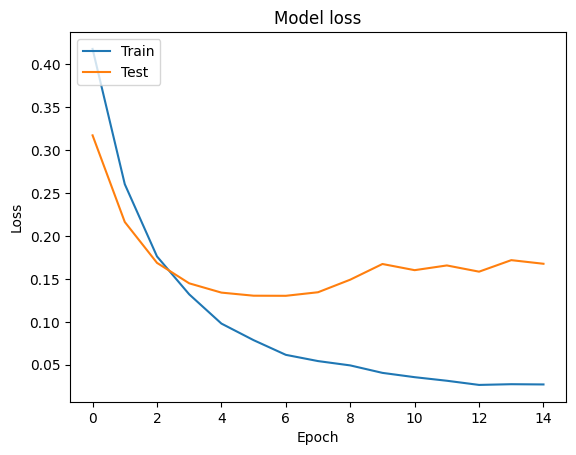

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save('model/model.h5')

## 4. Prediksi Rekomendasi

In [ ]:
print('Pilih user random')

recommendation_per_user = recommendations_df.groupby('user_id').size()

random_user =  recommendation_per_user[recommendation_per_user > 50].sample(1).index[0]

print(f'user_id: {random_user}')

Pilih user random
user_id: 11166044


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print(f'Game yang direkomendasikan untuk user: {random_user}')
print('===' * 25)

game_played_by_user = recommendations_df[recommendations_df.user_id == random_user]
game_not_played_df = games_with_metadata_df[~games_with_metadata_df['app_id'].isin(game_played_by_user.app_id.values)]
game_not_played = list(set(game_not_played_df['app_id']).intersection(set(app2app_encoded.keys())))
game_not_played = [[app2app_encoded.get(x)] for x in game_not_played if x in app2app_encoded]

user_encoder = user2user_encoded.get(random_user)
user_game_array = np.hstack(([[user_encoder]] * len(game_not_played), game_not_played))
user_game_array = [user_game_array[:, 0], user_game_array[:, 1]]

recommendations = model.predict(user_game_array).flatten()
top_recommendations = (-recommendations).argsort()[:10]

recommended_games_ids = [app_encoded2app.get(game_not_played[top_recommendations[x]][0]) for x in range(len(top_recommendations)) if game_not_played[top_recommendations[x]][0] in app_encoded2app]

results = []
top_recommendations_ids = []

for index, app_id in enumerate(game_not_played):
  recommendation = recommendations[index]
  id_ = app_encoded2app.get(app_id[0])

  if id_ in recommended_games_ids:
    top_recommendations_ids.append(id_)
    try:
      condition = (games_with_metadata_df.app_id == id_)
      if games_with_metadata_df[condition].empty:
        print(f"No metadata found for game ID {id_}")
        continue

      title = games_with_metadata_df[condition]['title'].values[0]
      rating = games_with_metadata_df[condition]['rating'].values[0]
      user_reviews = games_with_metadata_df[condition]['user_reviews'].values[0]
      price_final = games_with_metadata_df[condition]['price_final'].values[0]
      description = games_with_metadata_df[condition]['about_the_game'].values[0]
      tags = games_with_metadata_df[condition]['tags'].values[0]

      results.append({
        'title': title,
        'pred_recommendations': recommendation,
        'rating': rating,
        'user_reviews': user_reviews,
        'price_final': price_final,
        'about_the_game': description,
        'tags': tags
      })
    except Exception as e:
        print(f"Error processing game {id_}: {e}")
        continue

print("---" * 25)
print("> Top 10 game recommendations")
print("---" * 25)

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='pred_recommendations', ascending=False)

results_df

Game yang direkomendasikan untuk user: 11166044
1123/1123 [==============================] - 4s 3ms/step
---------------------------------------------------------------------------
> Top 10 game recommendations
---------------------------------------------------------------------------


title  pred_recommendations  \
2                                   Wallpaper Engine              0.977699   
4                      Halo Wars: Definitive Edition              0.970300   
0                                    Yakuza Kiwami 2              0.968398   
5                                       Escape : Lia              0.966156   
9                            Return of the Obra Dinn              0.965953   
8                                          Kung Fury              0.965289   
7  Romance of the Three Kingdoms VII with Power U...              0.964424   
6  The King's Request: Physiology and Anatomy Rev...              0.963121   
1                                     Silicon Zeroes              0.962511   
3                                      Sakura Hime 2              0.961542   

                    rating  user_reviews  price_final  \
2  Overwhelmingly Positive      637341.0         4.00   
4            Very Positive        6330.0        19.99   
0  Overwhelmingly Positive        9494.0        19.99   
5          Mostly Negative          26.0         0.00   
9  Overwhelmingly Positive       19156.0        19.99   
8  Overwhelmingly Positive       16692.0         0.00   
7          Mostly Positive          88.0        19.99   
6            Very Positive         159.0         0.00   
1            Very Positive         215.0        14.99   
3            Very Positive         647.0         2.79   

                                      about_the_game  \
2  Wallpaper Engine enables you to use live wallp...   
4  Halo Wars: Definitive Edition is an enhanced v...   
0  Kazuma Kiryu thought his Tojo Clan days were b...   
5  ‘Escape : Lia’ is a 3D first-person, horror ro...   
9  LOST AT SEA, 1803 the good ship 'OBRA DINN' --...   
8                                                      
7  To commemorate Kou Shibusawa's 35th anniversar...   
6  Are you studying Physiology or Anatomy or inte...   
1  The makers of Manufactoria return with a new o...   
3  Badge Game Introduction Surrounded by many bea...   

                                                tags  
2  Mature, Utilities, Software, Anime, Design & I...  
4  Strategy, RTS, Multiplayer, Base-Building, Sci...  
0  Action, Story Rich, RPG, Beat 'em up, Sexual C...  
5                                                     
9  Detective, Mystery, Puzzle, Story Rich, Atmosp...  
8                                                     
7                                           Strategy  
6  Adventure, RPG, Free to Play, Casual, RPGMaker...  
1  Simulation, Indie, Programming, Puzzle, Single...  
3  Sexual Content, Nudity, Simulation, Indie, Mat...

# Cosine Similarity (Content-Based Filtering)

## Seleksi Fitur

In [ ]:
selected_columns = ['title', 'about_the_game', 'tags']

games_with_metadata_df = games_with_metadata_df[selected_columns]

In [ ]:
games_with_metadata_df

title  \
0              Prince of Persia: Warrior Within™   
1                        BRINK: Agents of Change   
2                   Monaco: What's Yours Is Mine   
3                             Escape Dead Island   
4                        Dungeon of the ENDLESS™   
...                                          ...   
50867  I Expect You To Die 3: Cog in the Machine   
50868                                   PAYDAY 3   
50869                                 Eternights   
50870                        Forgive Me Father 2   
50871                                  FatalZone   

                                          about_the_game  \
0      Enter the dark underworld of Prince of Persia ...   
1                                                          
2      Monaco: What's Yours Is Mine is a single playe...   
3      Escape Dead Island is a Survival-Mystery game ...   
4      A few hundred condemned criminals were being s...   
...                                                  ...   
50867  Just when you thought you were out, we’re pull...   
50868  Step out of retirement back into the life of c...   
50869  Eternights is a unique blend of dating and act...   
50870  Journey once again into a malevolent world ins...   
50871  Survival takes a deadly toll… Exterminate hord...   

                                                    tags  
0      Action, Adventure, Parkour, Third Person, Grea...  
1                                                         
2      Co-op, Stealth, Indie, Heist, Local Co-Op, Str...  
3      Zombies, Adventure, Survival, Action, Third Pe...  
4      Rogue-like, Strategy, Tower Defense, Pixel Gra...  
...                                                  ...  
50867  Adventure, Action, Simulation, Puzzle, VR, Fir...  
50868  Heist, Co-op, Action, Crime, FPS, Multiplayer,...  
50869  Anime, Dating Sim, Hack and Slash, Romance, JR...  
50870  Early Access, FPS, Action, Retro, Lovecraftian...  
50871  Early Access, Action Roguelike, Bullet Hell, Z...  

[50872 rows x 3 columns]

In [ ]:
print(f"Isi datanya ada {games_with_metadata_df.shape[0]} baris, dan {games_with_metadata_df.shape[1]} kolom")

Isi datanya ada 50872 baris, dan 3 kolom


In [ ]:
games_with_metadata_df.isnull().sum()

title             0
about_the_game    0
tags              0
dtype: int64

In [ ]:
features_combine = games_with_metadata_df['title'] + ' ' + games_with_metadata_df['about_the_game'] + ' ' + games_with_metadata_df['tags']

features_combine

0        Prince of Persia: Warrior Within™ Enter the da...
1                                BRINK: Agents of Change  
2        Monaco: What's Yours Is Mine Monaco: What's Yo...
3        Escape Dead Island Escape Dead Island is a Sur...
4        Dungeon of the ENDLESS™ A few hundred condemne...
                               ...                        
50867    I Expect You To Die 3: Cog in the Machine Just...
50868    PAYDAY 3 Step out of retirement back into the ...
50869    Eternights Eternights is a unique blend of dat...
50870    Forgive Me Father 2 Journey once again into a ...
50871    FatalZone Survival takes a deadly toll… Exterm...
Length: 50872, dtype: object

In [ ]:
print('Data type: {}'.format(type(features_combine)))

Data type: <class 'pandas.core.series.Series'>


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')

In [ ]:
feature_vector = vectorizer.fit_transform(features_combine)

In [ ]:
print(feature_vector)

  (0, 80041)	0.02968887601945926
  (0, 23531)	0.03808438574446703
  (0, 111489)	0.021784394176967106
  (0, 72166)	0.03323591474493235
  (0, 84711)	0.030581268336748013
  (0, 96266)	0.024722353008503232
  (0, 36548)	0.06661246831796763
  (0, 42944)	0.04280189026991947
  (0, 92144)	0.04779050970462946
  (0, 44790)	0.04729253454888041
  (0, 21237)	0.03507745334682292
  (0, 10388)	0.03011917416745675
  (0, 76860)	0.034136863537263196
  (0, 91478)	0.02063944723380145
  (0, 93729)	0.030359735316051403
  (0, 43504)	0.03141874835291693
  (0, 75467)	0.028552036462610408
  (0, 74302)	0.05887317242774257
  (0, 5462)	0.020771524906877527
  (0, 22376)	0.04930591505150921
  (0, 66318)	0.04041856534094166
  (0, 58287)	0.07123804554859266
  (0, 47660)	0.06368358439020833
  (0, 91564)	0.08716478914971215
  (0, 63886)	0.05835823146827955
  :	:
  (50871, 79337)	0.04097854638608182
  (50871, 114081)	0.11265248001376398
  (50871, 48042)	0.040054958301072204
  (50871, 53927)	0.02442436443108829
  (50871, 10

In [ ]:
print(vectorizer.vocabulary_)

{'prince': 78694, 'persia': 75451, 'warrior': 109565, 'enter': 33973, 'dark': 26348, 'underworld': 105401, 'sword': 98391, 'slashing': 92152, 'sequel': 89369, 'critically': 24786, 'acclaimed': 4774, 'sands': 87383, 'time': 101523, 'trade': 102744, 'hunted': 48690, 'dahaka': 26028, 'immortal': 49855, 'incarnation': 50223, 'fate': 36763, 'seeking': 88961, 'divine': 29804, 'retribution': 84248, 'embarks': 33191, 'path': 74568, 'carnage': 18656, 'mystery': 67937, 'defy': 27415, 'preordained': 78442, 'death': 26878, 'journey': 53584, 'leads': 58074, 'infernal': 50666, 'core': 23782, 'cursed': 25499, 'island': 52257, 'stronghold': 96641, 'harbouring': 45454, 'mankind': 62028, 'greatest': 43511, 'fears': 36930, 'grim': 43733, 'resolve': 83962, 'bitter': 14317, 'defiance': 27331, 'mastery': 62698, 'deadly': 26807, 'new': 69409, 'combat': 22261, 'arts': 9656, 'rise': 85043, 'level': 58590, 'warriorship': 109570, 'defend': 27304, 'enemy': 33706, 'shall': 89829, 'away': 11129, 'life': 58861, 'def

In [ ]:
feature_vector.shape

(50872, 162731)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def batch_cosine_similarity(matrix, batch_size=5000):
    n_samples = matrix.shape[0]
    similarity_matrix = np.zeros((n_samples, n_samples))

    for start in range(0, n_samples, batch_size):
      end = min(start + batch_size, n_samples)
      batch = matrix[start:end]
      similarity_batch = cosine_similarity(batch)
      similarity_matrix[start:end, start:end] = similarity_batch

    return similarity_matrix

similarity_matrix = batch_cosine_similarity(feature_vector)

print(similarity_matrix)

[[1.         0.01449673 0.01343261 ... 0.         0.         0.        ]
 [0.01449673 1.         0.         ... 0.         0.         0.        ]
 [0.01343261 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.03466415 0.0752986 ]
 [0.         0.         0.         ... 0.03466415 1.         0.04561734]
 [0.         0.         0.         ... 0.0752986  0.04561734 1.        ]]


In [ ]:
similarity_matrix.shape

(50872, 50872)

## 3. Prediksi

In [ ]:
input_game = input('Nama Game: ')

Nama Game: Tom Clancy 


In [ ]:
list_game = games_with_metadata_df['title'].tolist()
print(list_game)

['Prince of Persia: Warrior Within™', 'BRINK: Agents of Change', "Monaco: What's Yours Is Mine", 'Escape Dead Island', 'Dungeon of the ENDLESS™', 'METAL SLUG 3', 'Enclave', 'Men of War: Assault Squad 2 - Deluxe Edition upgrade', 'Hyperdimension Neptunia Re;Birth1', 'The Sum of All Fears', 'Cold Fear™', 'LEGO® Harry Potter: Years 1-4', 'Hearts of Iron 2 Complete', 'Osmos', 'Comanche 4', 'Inquisitor', 'FORM', 'Homesick', 'Borderlands 2: Headhunter 4: Wedding Day Massacre', 'Bridge Constructor', 'Angvik', 'Sniper Elite 3 - Camouflage Weapons Pack', 'Chasm', 'Dandelion - Wishes brought to you -', 'Eradicator', 'Controller Companion', 'Herald: An Interactive Period Drama - Book I & II', 'Take Command - 2nd Manassas', 'GUILTY GEAR 2 -OVERTURE-', 'Aselia the Eternal -The Spirit of Eternity Sword-', 'The House in Fata Morgana Original Soundtrack', 'Offworld Trading Company - Soundtrack DLC', 'Luckitown', 'Barony', 'Retro/Grade', 'Dreamfall Chapters', 'Meltdown', 'NOT A HERO', 'Disciples Sacred

In [ ]:
import difflib

find_close_match = difflib.get_close_matches(input_game, list_game)
print(find_close_match)

["Tom Clancy's EndWar™", 'Worms Clan Wars', "Tom Clancy's Ghost Recon®"]


In [ ]:
close_match = find_close_match[0]
print(close_match)

Tom Clancy's EndWar™


In [ ]:
game_index = games_with_metadata_df[games_with_metadata_df['title'] == close_match].index[0]
print(game_index)

6981


In [ ]:
similarity_score = list(enumerate(similarity_matrix[game_index]))
sorted_similar_game = sorted(similarity_score, key=lambda x:x[1], reverse=True)
sorted_similar_game[0:20]

[(6981, 1.0),
 (7145, 0.20015481697658974),
 (6139, 0.19324771937078697),
 (8351, 0.17343108664053114),
 (7577, 0.1730152956995909),
 (6360, 0.16405027952790094),
 (5337, 0.16240560257689285),
 (7865, 0.16149858136583006),
 (8937, 0.1603145865832391),
 (9832, 0.15521809682298493),
 (5701, 0.15193754487007888),
 (8812, 0.14815451611366404),
 (5854, 0.1479073595334106),
 (8003, 0.14614086510891428),
 (6426, 0.14354449250782883),
 (5132, 0.14317794793541874),
 (8440, 0.1427577430828726),
 (8166, 0.14208377113873402),
 (7354, 0.1386713650417151),
 (7672, 0.13830870513786023)]

In [ ]:
print(f"Game yang direkomendasikan untuk {input_game}:\n")

i=1
for game in sorted_similar_game:
  index = game[0]
  title = games_with_metadata_df[games_with_metadata_df.index == index]['title'].values[0]
  if (i<=20):
    print(f'{i}. {title}')
    i+=1

Game yang direkomendasikan untuk Tom Clancy :

1. Tom Clancy's EndWar™
2. Frontline: The Great Patriotic War
3. Rise of Liberty
4. Gary Grigsby's War in the East
5. Commander: Modern War
6. Strategic Command WWII: War in Europe
7. Men of War: Assault Squad
8. Commander: The Great War
9. Order of Battle: World War II
10. Tom Clancy's The Division™ - Underground
11. RISK: Global Domination
12. Strategic Mind: Fight for Freedom
13. Making History: The Second World War
14. Gary Grigsby's War in the East 2
15. Supreme Ruler The Great War
16. Hearts of Iron III
17. Imperial Glory
18. Tom Clancy's The Division™ - Let it Snow Pack
19. Strategic Command: American Civil War
20. Men of War: Condemned Heroes
